# Test xarray on CMIP6 dataset

1. Import o2 dataset from multiple files as a xarray.Dataset object
2. Define point coordinates and find nearest corresponding grid point
3. Extract subset of o2 dataset for grid point
4. Plot o2 values: time vs. depth with o2 color scale

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import xarray as xr
import numpy as np

In [3]:
from geopy import distance

# 1. Import data as a xarray.Dataset object

In [4]:
## Monthly historical NorESM2-LM 'o2' or 'co3' files
#input_files = './data/NTK-data/modeldata/ETHZ_CMIP6/historical/Omon/o2/NorESM2-LM/r1i1p1f1/o2_Omon_NorESM2-LM_historical_r1i1p1f1_gr_*.nc'
#input_files = './data/NTK-data/modeldata/ETHZ_CMIP6/historical/Omon/co3/NorESM2-LM/r1i1p1f1/co3_Omon_NorESM2-LM_historical_r1i1p1f1_gr_*.nc'
#dset = xr.open_mfdataset(input_files, combine='by_coords')
#title_label = 'hist'

## Yearly "historical + SSP###" NorESM-LM files 
input_files_hist = './data/NTK-data/modeldata/ETHZ_CMIP6/historical/Oyr/o2/NorESM2-LM/r1i1p1f1/o2_Oyr_NorESM2-LM_historical_r1i1p1f1_gr_*.nc'
#input_files_hist = './data/NTK-data/modeldata/ETHZ_CMIP6/historical/Oyr/ph/NorESM2-LM/r1i1p1f1/ph_Oyr_NorESM2-LM_historical_r1i1p1f1_gr_*.nc'
dset_hist = xr.open_mfdataset(input_files_hist, combine='by_coords')

#input_files_ssp126 = './data/NTK-data/modeldata/ETHZ_CMIP6/ssp126/Oyr/o2/NorESM2-LM/r1i1p1f1/o2_Oyr_NorESM2-LM_ssp126_r1i1p1f1_gr_*.nc'
#input_files_ssp126 = './data/NTK-data/modeldata/ETHZ_CMIP6/ssp126/Oyr/ph/NorESM2-LM/r1i1p1f1/ph_Oyr_NorESM2-LM_ssp126_r1i1p1f1_gr_*.nc'
#dset_ssp126 = xr.open_mfdataset(input_files_ssp126, combine='by_coords')
#dset = xr.combine_by_coords([ dset_hist , dset_ssp126])
#title_label = 'hist+ssp126'

input_files_ssp585 = './data/NTK-data/modeldata/ETHZ_CMIP6/ssp585/Oyr/o2/NorESM2-LM/r1i1p1f1/o2_Oyr_NorESM2-LM_ssp585_r1i1p1f1_gr_*.nc'
#input_files_ssp585 = './data/NTK-data/modeldata/ETHZ_CMIP6/ssp585/Oyr/ph/NorESM2-LM/r1i1p1f1/ph_Oyr_NorESM2-LM_ssp585_r1i1p1f1_gr_*.nc'
dset_ssp585 = xr.open_mfdataset(input_files_ssp585, combine='by_coords')
dset = xr.combine_by_coords([ dset_hist , dset_ssp585])
title_label = 'hist+ssp585'

dset.attrs = dset_hist.attrs

### Print out info about the dataset

In [5]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 385, lev: 70, time: 251, vertices: 4)
Coordinates:
    longitude           (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    latitude            (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
  * lev                 (lev) float64 0.0 5.0 10.0 ... 6.25e+03 6.5e+03 6.75e+03
  * j                   (j) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384 385
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
  * time                (time) object 1850-07-02 12:00:00 ... 2100-07-02 12:00:00
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    lev_bnds            (time, lev, bnds) float64 dask.array<chunksize=(10, 70, 2), meta=np.ndarray>
    vertices_latitude   (time, j, i, vertices) float64 dask.array<chunksize=(10, 385, 360, 4), meta=n

### Attributes of main variable

In [6]:
eval('dset.' + dset.attrs['variable_id'] + '.attrs')

{'standard_name': 'mole_concentration_of_dissolved_molecular_oxygen_in_sea_water',
 'long_name': 'Dissolved Oxygen Concentration',
 'comment': "'Mole concentration' means number of moles per unit volume, also called 'molarity', and is used in the construction mole_concentration_of_X_in_Y, where X is a material constituent of Y.  A chemical or biological species denoted by X may be described by a single term such as 'nitrogen' or a phrase such as 'nox_expressed_as_nitrogen'.",
 'units': 'mol m-3',
 'original_name': 'o2lvl',
 'cell_methods': 'area: mean where sea time: mean',
 'cell_measures': 'area: areacello volume: volcello',
 'history': "2019-08-15T18:37:54Z altered by CMOR: Converted type from 'd' to 'f'."}

## 2. Define point coordinate and find nearest grid point

The test point at 23.0 degrees South and 12 degrees East is in the Benguela current, close to strong upwelling cells of the Benguela upwelling system. Calculate distances only for grid coordinates inside [lat_bbox,lon_bbox] region around ref_point.

The reference point is compared with (lat,lon) grid coordinates within the bounding box, using the distance function from geopy to identify the nearest one. The distance matrix is initialized with the same size as the (lat,lon) coordinate matrices, and a value expected to be larger than the minimum distance we want to find.

In [7]:
ref_point = (-23.0, 12.0)
[lat_bbox, lon_bbox] = [2.0, 2.0]

Extract latitude and longitude grid coordinates as pandas dataframes, for comparison with reference point.

In [8]:
lat = dset.latitude.to_pandas()
lon = dset.longitude.to_pandas()
dist = np.ones((dset.j.size, dset.i.size)) * 1.e6

In [9]:
for j in np.arange(dset.j.size):
    for i in np.arange(dset.i.size):
        if abs(lat.iloc[j,i] - ref_point[0]) < lat_bbox and \
        abs(lon.iloc[j,i] - ref_point[1]) < lon_bbox :
            grid_point = (lat.iloc[j,i], lon.iloc[j,i])
            dist[j,i] = distance.distance(ref_point, grid_point).km

The (j,i) indices corresponding to the minimum distance between a grid point and the reference point must be shifted by 1 to get the (j,i) table values, because python arrays start at [0,0] whereas the table values start at [1,1].

In [10]:
(j_index, i_index) = np.where(dist == dist.min())
j_value = j_index[0] + 1
i_value = i_index[0] + 1
print('Nearest grid point is ', dist.min(), ' km from ref_point, with (j,i) indices ', j_index, ', ', i_index, ' and values ', j_value, ',', i_value )

Nearest grid point is  57.53793866745897  km from ref_point, with (j,i) indices  [117] ,  [121]  and values  118 , 122


In [11]:
[lat_grd, lon_grd] = [lat.loc[j_value,i_value], lon.loc[j_value,i_value]]
print('Nearest grid point is located at (', lat_grd, ',', lon_grd, ')')

Nearest grid point is located at ( -23.236760218711662 , 11.500000000000028 )


# 3. Extract subset of o2 dataset

In [12]:
subset = dset.sel(j=j_value, i=i_value)

In [13]:
subset.data_vars

Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    lev_bnds            (time, lev, bnds) float64 dask.array<chunksize=(10, 70, 2), meta=np.ndarray>
    vertices_latitude   (time, vertices) float64 dask.array<chunksize=(10, 4), meta=np.ndarray>
    vertices_longitude  (time, vertices) float64 dask.array<chunksize=(10, 4), meta=np.ndarray>
    o2                  (time, lev) float32 dask.array<chunksize=(10, 70), meta=np.ndarray>

Convert the time variable from 'cftime' format used by xarray to 'datetime' format that can be used by matplotlib.

In [14]:
datetimeindex = subset.indexes['time'].to_datetimeindex()
subset['time'] = datetimeindex

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


In [15]:
data = eval('subset.' + dset.attrs['variable_id'] + '.to_pandas()')

In [16]:
data = data.swapaxes(0,1)

In [17]:
data

time,1850-07-02 12:00:00,1851-07-02 12:00:00,1852-07-02 12:00:00,1853-07-02 12:00:00,1854-07-02 12:00:00,1855-07-02 12:00:00,1856-07-02 12:00:00,1857-07-02 12:00:00,1858-07-02 12:00:00,1859-07-02 12:00:00,...,2091-07-02 12:00:00,2092-07-02 12:00:00,2093-07-02 12:00:00,2094-07-02 12:00:00,2095-07-02 12:00:00,2096-07-02 12:00:00,2097-07-02 12:00:00,2098-07-02 12:00:00,2099-07-02 12:00:00,2100-07-02 12:00:00
lev,,,,,,,,,,,,,,,,,,,,,
0.0,0.218279,0.218734,0.221627,0.219263,0.218321,0.220219,0.222653,0.218416,0.217871,0.220521,...,0.211226,0.213183,0.212403,0.211265,0.210519,0.212110,0.213068,0.209254,0.212315,0.210894
5.0,0.218355,0.218743,0.221662,0.219331,0.218320,0.220305,0.222679,0.218475,0.217950,0.220570,...,0.211269,0.213195,0.212419,0.211288,0.210560,0.212141,0.213148,0.209387,0.212345,0.210942
10.0,0.218215,0.218527,0.221475,0.219214,0.218090,0.220156,0.222511,0.218373,0.217870,0.220422,...,0.211134,0.213016,0.212286,0.211084,0.210435,0.211963,0.213082,0.209561,0.212121,0.210806
15.0,0.217955,0.218368,0.221162,0.219128,0.217814,0.219988,0.222407,0.218276,0.217754,0.220300,...,0.211040,0.212839,0.212206,0.210902,0.210322,0.211860,0.212991,0.209823,0.211992,0.210731
20.0,0.217608,0.217843,0.220856,0.218966,0.217280,0.219717,0.222325,0.218137,0.217582,0.220220,...,0.210830,0.212681,0.212113,0.210640,0.209894,0.211809,0.212654,0.209837,0.211909,0.210642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 4. Plot dataset

In [18]:
y = -data.index.values
x = data.columns.values
X,Y = np.meshgrid(x,y)

In [19]:
cbar_text = dset.attrs['variable_id']
cbar_units = eval('dset.' + dset.attrs['variable_id'] + '.attrs[\'units\']')
if cbar_units != '1':
    cbar_text = cbar_text + ' [' + cbar_units + ']'
title_text = eval('dset.' + dset.attrs['variable_id'] + '.attrs[\'long_name\']') + ' : {0:7.2f} N, {1:7.2f} E : {2!s}'.format(lat_grd,lon_grd,title_label)

Text(0.5,1,'Dissolved Oxygen Concentration :  -23.24 N,   11.50 E : hist+ssp585')

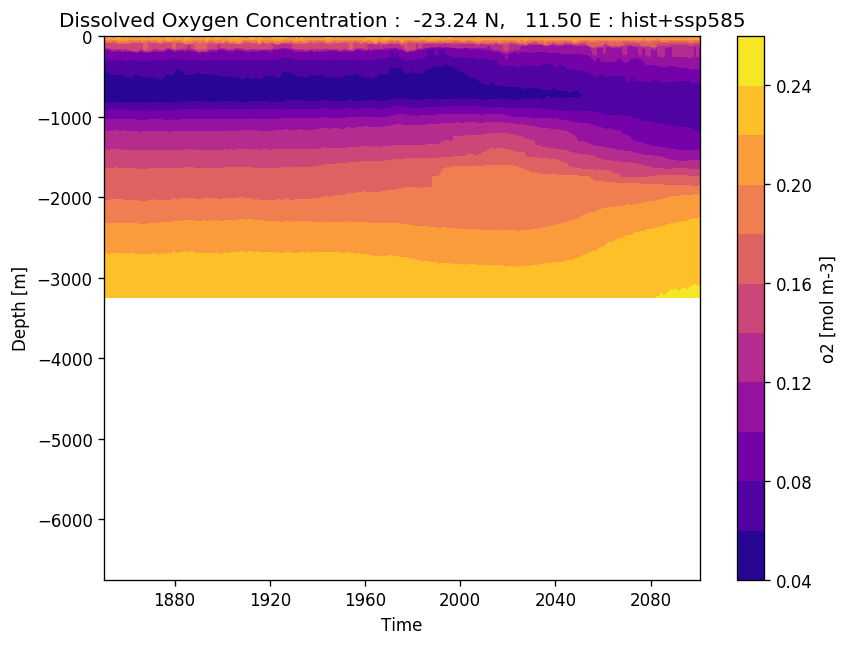

In [20]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
plt.contourf(X, Y, data, 10, cmap='plasma')
cbar = plt.colorbar()
cbar.set_label(cbar_text)
plt.xlabel('Time')
plt.ylabel('Depth [m]')
plt.title(title_text)

Text(0.5,1,'Dissolved Oxygen Concentration :  -23.24 N,   11.50 E : hist+ssp585')

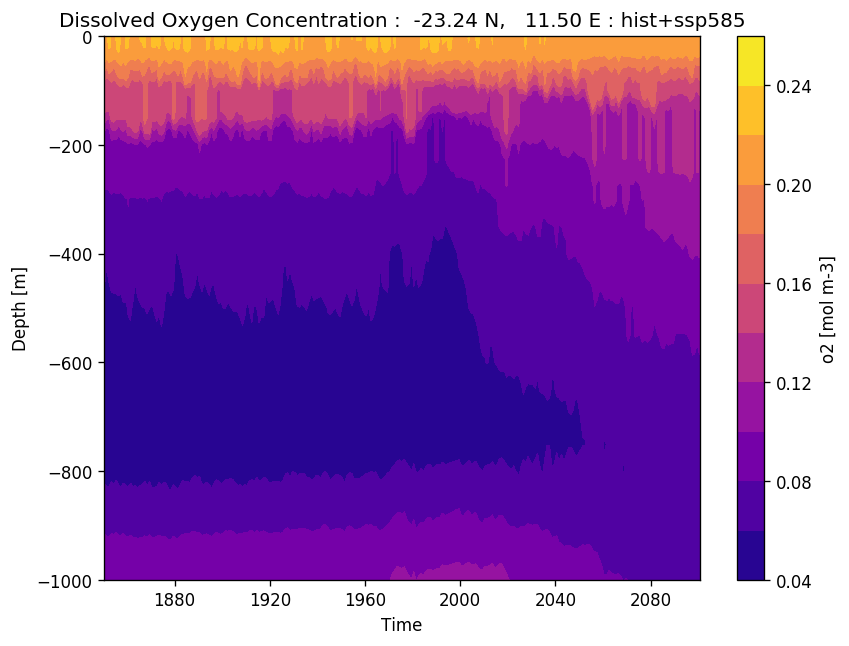

In [21]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
plt.contourf(X, Y, data, 10, cmap='plasma')
plt.ylim(-1000.0 , 0.0)
cbar = plt.colorbar()
cbar.set_label(cbar_text)
plt.xlabel('Time')
plt.ylabel('Depth [m]')
plt.title(title_text)